In [2]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [3]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)

Число обусловленности такой матрицы будет большим

In [4]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.04265001946, 406095.0425928014)

In [5]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

In [6]:
from optimizers.CG import CG, PreconditionedCG

%load_ext autoreload
%autoreload 2

In [7]:
final_cg, score_cg, hist_cg = CG(A, b, x0).optimize()

cg_iter = len(hist_cg["x"])
print('CG finished after {} iterations with score {}'.format(cg_iter, score_cg))

CG finished after 1002 iterations with score 4.229193442340575e-10


Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [8]:
L = sp.tril(A)
D = sp.diags(1 / A.diagonal())
U = sp.triu(A)

# Symmetric Gauss-Seidel preconditioner
M = L.dot(D).dot(U)

final_pcg, score_pcg, hist_pcg = PreconditionedCG(A, b, x0, M).optimize()

pcg_iter = len(hist_pcg["x"])
print('CG finished after {} iterations with score {}'.format(pcg_iter, score_pcg))

CG finished after 359 iterations with score 6.58756793988919e-09


Сравните результат работы предобусловленной и непредобусловленной версии

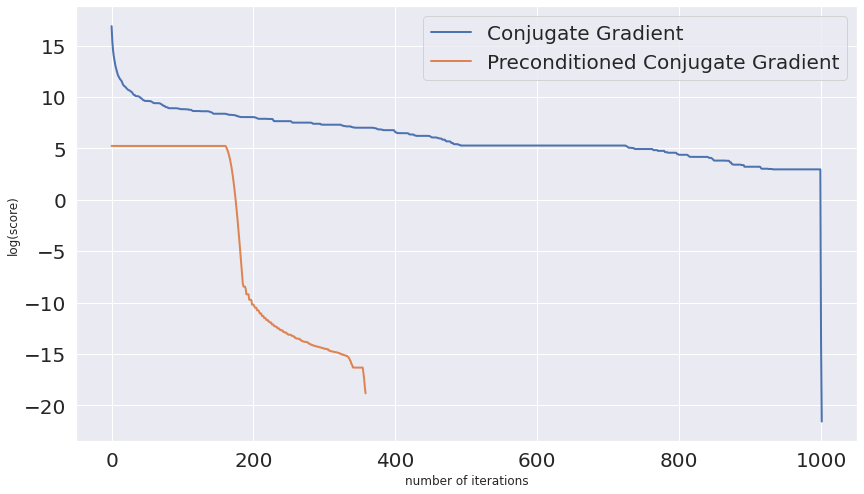

In [10]:
it_cg = np.arange(cg_iter)
scores_cg = hist_cg["scores"]

it_pcg = np.arange(pcg_iter)
scores_pcg = hist_pcg["scores"]

sns.set()
plt.figure(figsize = (14, 8))

plt.plot(it_cg, np.log(scores_cg), linewidth=2, label='Conjugate Gradient')
plt.plot(it_pcg, np.log(scores_pcg), linewidth=2, label='Preconditioned Conjugate Gradient')

plt.xlabel('number of iterations')
plt.ylabel('log(score)')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best", fontsize=20)

__Вывод:__ Как мы видим из полученных графиков, предобусловленный метод сопряжённых градиентов сходится в 3 раза быстрее, чем классический метод сопряжённых градиентов на матрицах с большим числом обусловленности.